## Project Name: Rain Prediction using ML models and PyCaret
# In this project we will train a model to predict whether it will rain tomorrow.
# We use multiple ML models and AutoML (PyCaret)

In [3]:
# Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import scipy.stats as stats
import pylab
import pickle

In [4]:
%matplotlib inline

In [5]:
# --- Step 2: Load Data ---
df = pd.read_csv("rain_forecasting.csv")

print(df.shape)
df.head()

(1000, 12)


,Date,Location,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,WindSpeed9am,WindSpeed3pm,RainToday,RainTomorrow
0,2025-01-01,Mumbai,20.6,28.7,67,37,1001.4,1007.0,10,13,No,No
1,2025-01-02,New Delhi,29.3,35.8,46,34,1008.3,1005.7,10,5,No,No
2,2025-01-03,Mumbai,26.0,42.5,74,89,1009.6,998.9,16,23,Yes,Yes
3,2025-01-04,Kolkata,24.0,39.6,94,38,1010.6,1002.3,16,9,No,No
4,2025-01-05,New Delhi,17.3,41.1,67,30,1005.6,999.4,14,23,Yes,No


In [6]:
pd.set_option("display.max_columns", None)

In [7]:
#Step 3: Feature Classification ---
num_var = [col for col in df.columns if df[col].dtype != 'O']
discrete_var = [col for col in num_var if df[col].nunique() <= 25]
cont_var = [col for col in num_var if col not in discrete_var]
categ_var = [col for col in df.columns if col not in num_var]

In [8]:
#Step 4: Missing Values Check ---
print(df.isnull().sum())

Date            0
Location        0
MinTemp         0
MaxTemp         0
Humidity9am     0
Humidity3pm     0
Pressure9am     0
Pressure3pm     0
WindSpeed9am    0
WindSpeed3pm    0
RainToday       0
RainTomorrow    0
dtype: int64


In [9]:
# --- Step 5: Encode Categorical Variables ---
# Binary Encoding for RainToday & RainTomorrow
df["RainToday"] = df["RainToday"].map({"No": 0, "Yes": 1})
df["RainTomorrow"] = df["RainTomorrow"].map({"No": 0, "Yes": 1})

In [10]:
# One-Hot Encode Location
df = pd.get_dummies(df, columns=["Location"], drop_first=True)

In [11]:
# --- Step 6: Feature Engineering on Date ---
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day
df.drop("Date", axis=1, inplace=True)

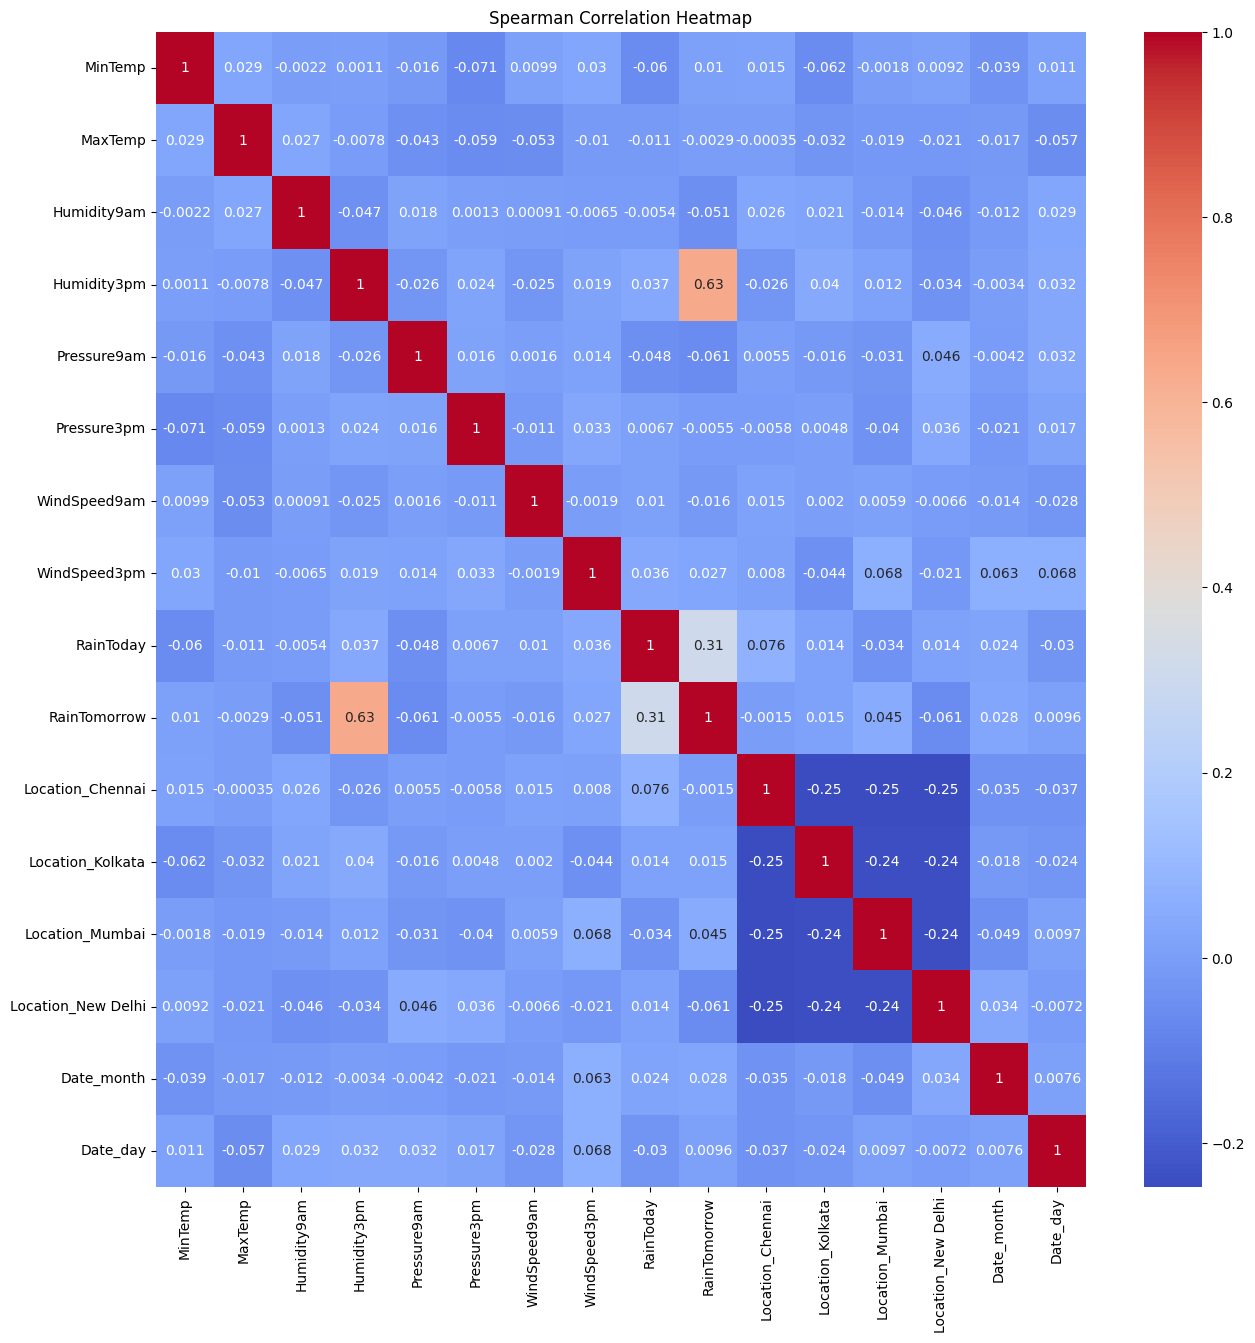

In [12]:
# Step 7: Correlation Heatmap ---
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(method="spearman"), annot=True, cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.show()

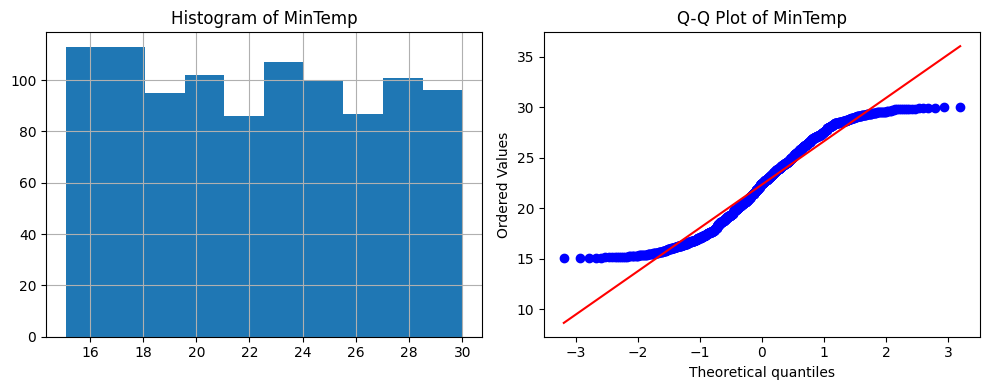

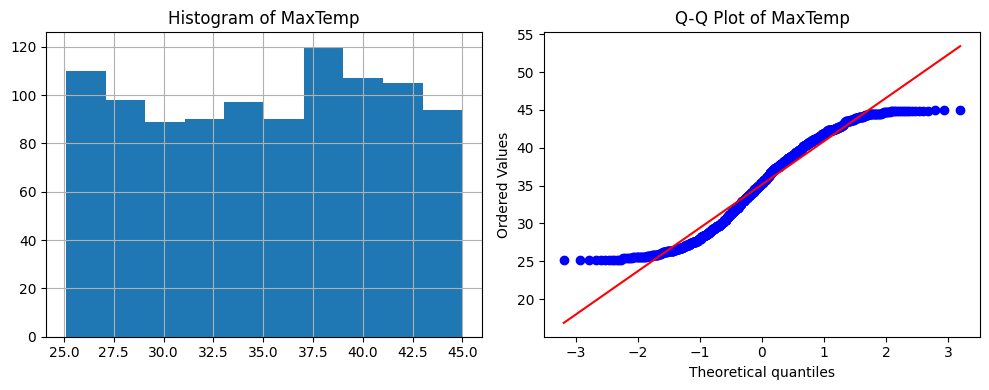

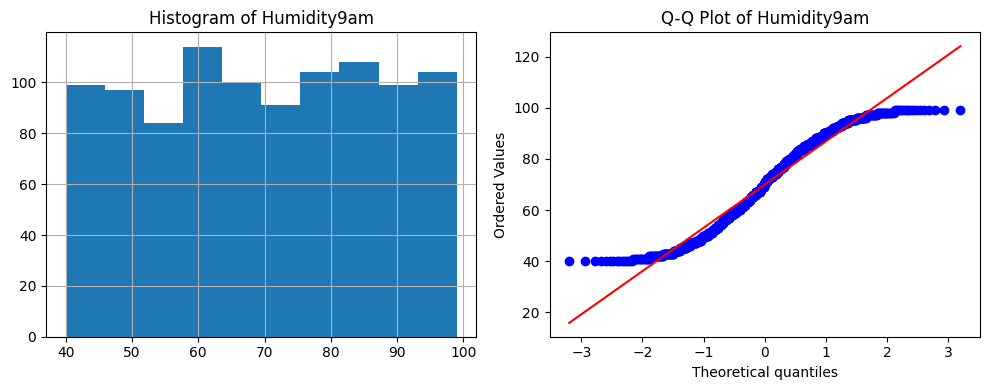

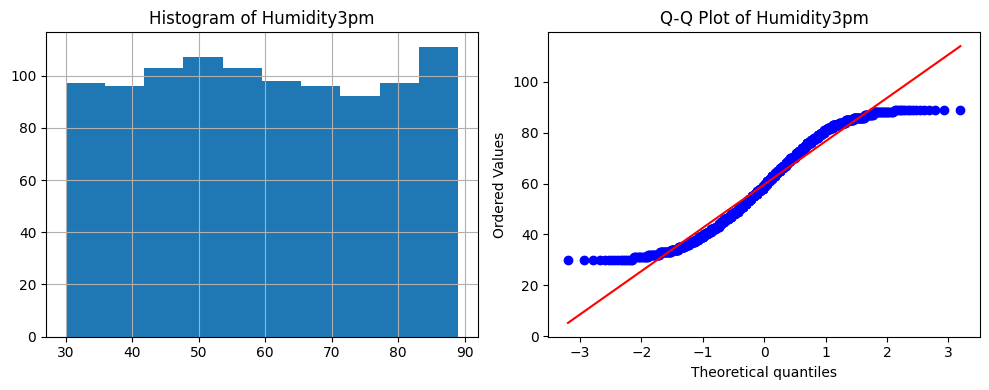

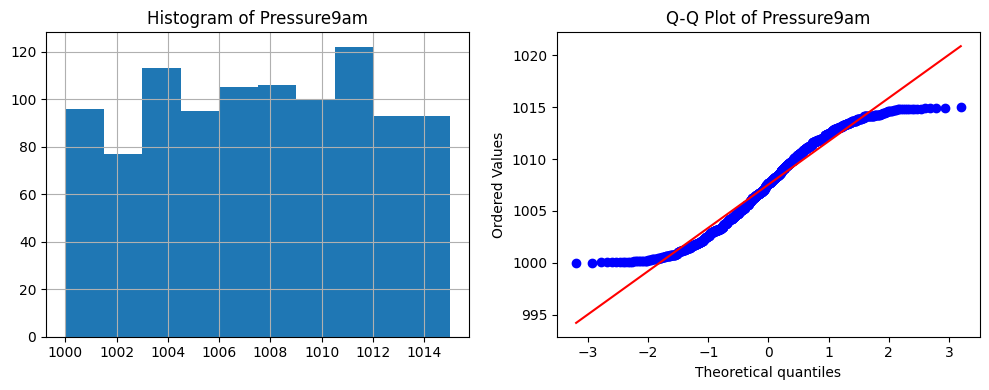

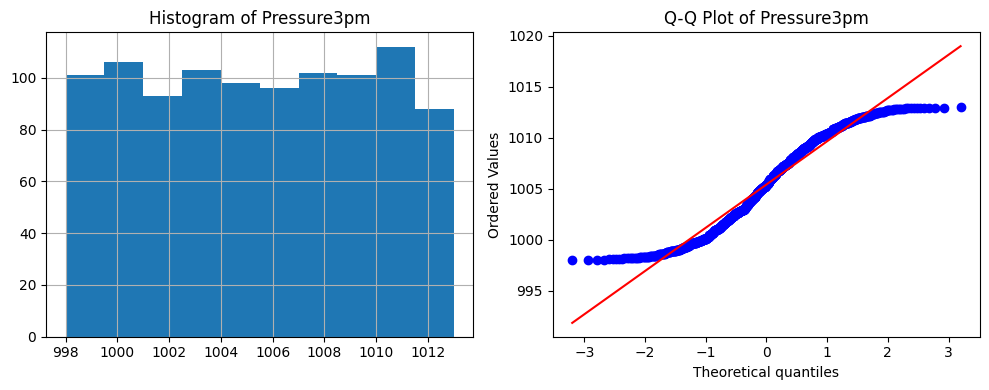

In [13]:
# --- Step 8: Continuous Variable Analysis ---
def plot_curve(data, feature):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    data[feature].hist()
    plt.title(f"Histogram of {feature}")

    plt.subplot(1, 2, 2)
    stats.probplot(data[feature], dist="norm", plot=pylab)
    plt.title(f"Q-Q Plot of {feature}")
    plt.tight_layout()
    plt.show()

for feature in cont_var:
    plot_curve(df, feature)

In [14]:
# --- Step 9: Prepare Data for ML ---
x = df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X = pd.DataFrame(X_scaled, columns=x.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
x.head()

,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,WindSpeed9am,WindSpeed3pm,RainToday,Location_Chennai,Location_Kolkata,Location_Mumbai,Location_New Delhi,Date_month,Date_day
0,20.6,28.7,67,37,1001.4,1007.0,10,13,0,False,False,True,False,1,1
1,29.3,35.8,46,34,1008.3,1005.7,10,5,0,False,False,False,True,1,2
2,26.0,42.5,74,89,1009.6,998.9,16,23,1,False,False,True,False,1,3
3,24.0,39.6,94,38,1010.6,1002.3,16,9,0,False,True,False,False,1,4
4,17.3,41.1,67,30,1005.6,999.4,14,23,1,False,False,False,True,1,5


In [17]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: RainTomorrow, dtype: int64

## --- Step 10: ML Models ---

Random Forest
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       138
           1       0.82      0.68      0.74        62

    accuracy                           0.85       200
   macro avg       0.84      0.81      0.82       200
weighted avg       0.85      0.85      0.85       200

AUC: 0.8061009817671809


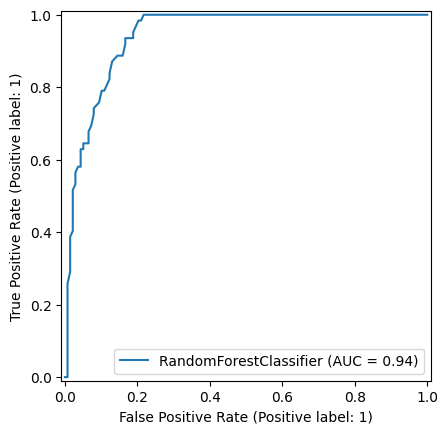

In [18]:
## Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest\n", classification_report(y_test, rf_pred))
RocCurveDisplay.from_estimator(rf, X_test, y_test)
print("AUC:", roc_auc_score(y_test, rf_pred))

GaussianNB
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       138
           1       0.83      0.71      0.77        62

    accuracy                           0.86       200
   macro avg       0.85      0.82      0.84       200
weighted avg       0.86      0.86      0.86       200

AUC: 0.8222300140252455


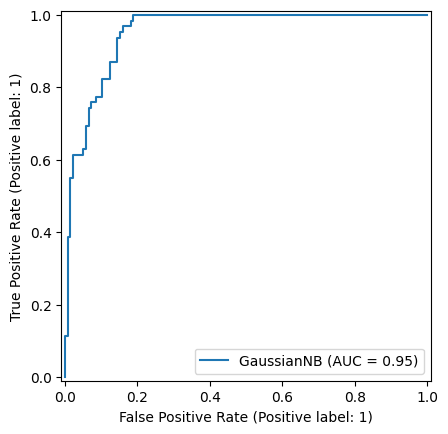

In [19]:
## GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
print("GaussianNB\n", classification_report(y_test, gnb_pred))
RocCurveDisplay.from_estimator(gnb, X_test, y_test)
print("AUC:", roc_auc_score(y_test, gnb_pred))

KNN
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       138
           1       0.66      0.44      0.52        62

    accuracy                           0.76       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.74      0.76      0.74       200

AUC: 0.6670172978027116


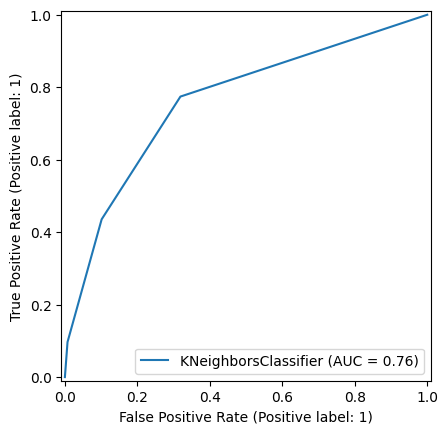

In [20]:
## KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KNN\n", classification_report(y_test, knn_pred))
RocCurveDisplay.from_estimator(knn, X_test, y_test)
print("AUC:", roc_auc_score(y_test, knn_pred))

c:\Users\91739\OneDrive\Desktop\MY_PROJECTS\Rain_Prediction_ML\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:03:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       138
           1       0.75      0.76      0.75        62

    accuracy                           0.84       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.85      0.84      0.85       200

AUC: 0.8210612435717625


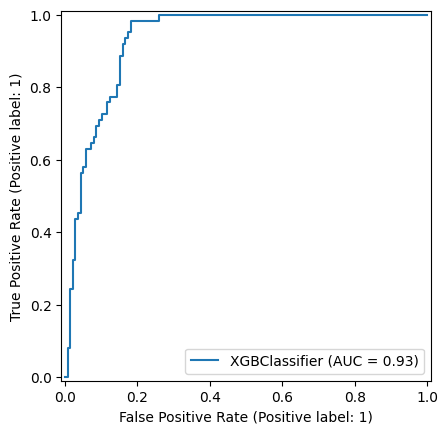

In [21]:
## XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("XGBoost\n", classification_report(y_test, xgb_pred))
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
print("AUC:", roc_auc_score(y_test, xgb_pred))


#select the model with the highest AUC score:

In [22]:
# --- Step 11: Save Best Model ---
with open("rain_XGB_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

In [23]:
# Load model example
model = pickle.load(open("rain_XGB_model.pkl", "rb"))

## --- Step 12: AutoML with PyCaret ---

In [24]:
from pycaret.classification import *
pycaret_df = pd.concat([X, y], axis=1)
s = setup(data=pycaret_df, target="RainTomorrow", session_id=123)


,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(1000, 16)"
4,Transformed data shape,"(1000, 16)"
5,Transformed train set shape,"(700, 16)"
6,Transformed test set shape,"(300, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [25]:
best_model = compare_models()
best_model

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)

In [26]:
finalize_model(best_model)


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['MinTemp', 'MaxTemp',
                                             'Humidity9am', 'Humidity3pm',
                                             'Pressure9am', 'Pressure3pm',
                                             'WindSpeed9am', 'WindSpeed3pm',
                                             'RainToday', 'Location_Chennai',
                                             'Location_Kolkata',
                                             'Location_Mumbai',
                                             'Location_New Delhi', 'Date_month',
                                             'Date_day'],
                                    transformer=SimpleImpute...
                                                              missing_values=nan,
                                                              strategy='most_frequent'))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True,
                                 fit_intercept=True, max_iter=None,
                                 positive=False, random_state=123,
                                 solver='auto', tol=0.0001))],
         verbose=False)

In [ ]:
save_model(best_model, 'best_pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['MinTemp', 'MaxTemp',
                                              'Humidity9am', 'Humidity3pm',
                                              'Pressure9am', 'Pressure3pm',
                                              'WindSpeed9am', 'WindSpeed3pm',
                                              'RainToday', 'Location_Chennai',
                                              'Location_Kolkata',
                                              'Location_Mumbai',
                                              'Location_New Delhi', 'Date_month',
                                              'Date_day'],
                                     transformer=SimpleImpute...
                                                               missing_values=nan,
                                                               strategy='

: 